In [ ]:
import os

import nibabel as nib
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
import itertools
import seaborn as sns

In [ ]:
LABEL_NAME = {
    0: 'background',
    1: 'displaced',
    2: 'non-displaced',
    3: 'buckle',
    4: 'segmental',
    -1: 'undefined'
}


def get_frac_type(label):
    LABEL_NAME[label]

rib_frac_types = {name: 0 for name in LABEL_NAME.values()}
rib_data = defaultdict(list)
nr_frac = defaultdict(int)

# for index, row in pd.read_csv('train/ribfrac-train-info-1.csv').iterrows():
#     rib_data[row[0]].append(row[2])
#     nr_frac[row[0]] += 1
#     if row[2] != 0:
#         rib_frac_types[get_frac_type(row[2])] += 1
        
# for index, row in pd.read_csv('train/ribfrac-train-info-2.csv').iterrows():
#     rib_data[row[0]].append(row[2])
#     nr_frac[row[0]] += 1
#     if row[2] != 0:
#         rib_frac_types[get_frac_type(row[2])] += 1
        
for index, row in pd.read_csv('train/ribfrac-val-info.csv').iterrows():
    rib_data[row[0]].append(row[2])
    nr_frac[row[0]] += 1
    if row[2] != 0:
        rib_frac_types[get_frac_type(row[2])] += 1
        
#print(rib_data)
print(nr_frac)
#print(rib_frac_types)

total_rib_frac = sum(rib_frac_types.values())

avg_frac = total_rib_frac/len(nr_frac)
print('average fractures', avg_frac)
print('total fractures',total_rib_frac)

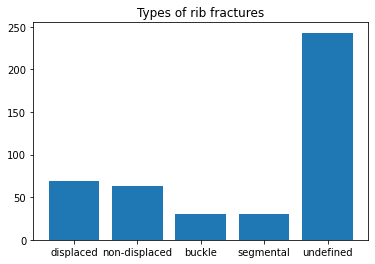

In [2]:
plt.bar(rib_frac_types.keys(),rib_frac_types.values())
plt.title('Types of rib fractures')
plt.show()

In [8]:
def get_axis(scan, label, idx):
    xs = []
    ys = []
    for i, slice_ in enumerate(scan[idx[0]:idx[-1]]):
        #frac = np.where(slice_ == label, 1, 0)
        #xs.append(max(np.sum(frac, axis = 1)))
        #ys.append(max(np.sum(frac, axis = 0)))
        x, y = np.where(slice_ == label, 1, 0)
        min_x, max_x, min_y, max_y = np.min(x), np.max(x), np.min(y), np.max(y)
    return min_x, max_x, min_y, max_y


def center_of_mass(crop_3d: np.array) -> tuple:
    """
    computes the center of mass of the given 3d volume (x,y,z).
    the provided 3d chunk has 1 (or mass M) for filled voxels and 0 if empty.
    the output is the index coordinates relative to the origin of the provided chunk.
    """
    x = np.arange(crop_3d.shape[0])
    y = np.arange(crop_3d.shape[1])
    z = np.arange(crop_3d.shape[2])
    vx, vy, vz = np.meshgrid(x, y, z, indexing='ij')
    r = np.vstack([vx.ravel(), vy.ravel(), vz.ravel()])
    m = crop_3d.reshape(1, -1)
    com = np.sum(r * m, axis=1) / np.sum(m)
    return com


def process_folder(folder_name, nr_frac, data_root: str, csv_filename: str = "data_info.csv"):
    data = []
    set_ = (
        "train"
        if "train" in folder_name
        else "val"
        if "val" in folder_name
        else "test"
    )
    slice_amt = defaultdict(int)
    for filename in tqdm(
        os.listdir(os.path.join(data_root, folder_name))[:4], desc=folder_name
    ):
        f = os.path.join(data_root, folder_name, filename)
        if filename.endswith("label.nii.gz"):
            data_dev = []
            scan = nib.load(f).get_fdata().T.astype(float)
            slice_amt[filename] = len(scan)
            label_f = f.replace("image", "label")
            labels = nib.load(label_f).get_fdata().T.astype(int)
            for i, slice in enumerate(scan):
                unique_labels = np.unique(labels[i]).tolist()
                data_temp = [
                            os.path.join(folder_name, filename),
                            i,
                            set_,
                            unique_labels,
                            ]
                data_dev.append(data_temp)
                
            df_slice = pd.DataFrame(
            data_dev,
            columns=[
                "img_filename",
                "slice_idx",
                "set",
                "labels",
            ],
            )
            fn = filename.split('-')[0]
            frac_data = []
            for i in range(1,nr_frac[fn]):
                idx = []
                for ind in df_slice.index:
                    if i in df_slice['labels'][ind]:
                        idx.append(df_slice['slice_idx'][ind])

                frac_type = ...  # TODO
                min_x, max_x, min_y, max_y = get_axis(scan, i, idx)
                min_z, max_z = idx[0], idx[-1]
                crop_3d = scan[idx[0]:idx[-1]], min_x:max_x+1, min_y:max_y+1]  # (z, x, y)
                com_z, com_x, com_y = center_of_mass(crop_3d)  # com relative to chunk
                com_x += min_x
                com_y += min_y
                com_z += min_z
                
                data.append([
                    os.path.join(folder_name, fn+'fracture'+str(i)),  # img_filename
                    set_,  # set
                    #(idx[-1] + idx[0])/ 2,  # height
                    #size_x,  # size_x
                    #size_y,  # size_y
                    #idx[-1] - idx[0],  # size_z
                    #idx,  # slices
                    frac_type,
                    min_x,
                    max_x,
                    min_y,
                    max_y,
                    min_z,
                    max_z,
                    com_x,
                    com_y,
                    com_z,
                ])

    df = pd.DataFrame(
        data,
        columns=[
            "img_filename",
            "set",
            #"height",
            #"size_x",
            #"size_y",
            #"size_z",
            #"slices",
            "frac_type",
            # bounding box limits
            "min_x",
            "max_x",
            "min_y",
            "max_y",
            "min_z",
            "max_z",
            # center of mass of chunk
            "com_x",
            "com_y",
            "com_z",
        ],
    )
    # size of bounding box
    df['size_x'] = df['max_x'] - df['min_x']
    df['size_y'] = df['max_y'] - df['min_y']
    df['size_z'] = df['max_z'] - df['min_z']
    # center of bounding box
    df['loc_x'] = (df['max_x'] + df['min_x']) / 2
    df['loc_y'] = (df['max_y'] + df['min_y']) / 2
    df['loc_z'] = (df['max_z'] + df['min_z']) / 2
    return df,slice_amt

data,slice_amt = process_folder('train',nr_frac,'')
print(slice_amt)
avg_slices = sum(slice_amt.values())/len(slice_amt)
print('average amount of slices:',avg_slices)
print('size of sections:',avg_slices/3)
high = avg_slices - avg_slices/3
low = high - avg_slices/3
print('definition fracture high height: >',high)
print('definition fracture mid height:',high,'<->',low)
print('definition fracture low height: <',low)

data['height_section'] = np.where(data['height'] > high, 'high', 'mid')
data['height_section'] = np.where(data['height'] < low, 'low', data['height_section'])
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.precision', 3, ): print(data)

# plt.bar(data['height_section'])

defaultdict(<class 'int'>, {'RibFrac421-label.nii.gz': 325, 'RibFrac422-label.nii.gz': 321, 'RibFrac423-label.nii.gz': 363})
average amount of slices: 336.3333333333333
size of sections: 112.1111111111111
definition fracture high height: > 224.22222222222223
definition fracture mid height: 224.22222222222223 <-> 112.11111111111113
definition fracture low height: < 112.11111111111113
                 img_filename    set  height  size_x  size_y  size_z  \
0   train\RibFrac421fracture1  train   122.5      14      16       9   
1   train\RibFrac421fracture2  train   132.5      19      18      17   
2   train\RibFrac421fracture3  train   141.0      16      28      16   
3   train\RibFrac421fracture4  train   219.5      19      32      11   
4   train\RibFrac422fracture1  train   104.5      17      26      17   
5   train\RibFrac422fracture2  train   142.0      19      30      20   
6   train\RibFrac422fracture3  train   159.0      19      25      18   
7   train\RibFrac422fracture4  train  

TypeError: bar() missing 1 required positional argument: 'height'

In [ ]:
# statistics of all dataframe attributes
data.describe()

In [ ]:
# src: https://seaborn.pydata.org/generated/seaborn.histplot.html
sns.histplot(data=data, x="size_x", hue="frac_type")
sns.histplot(data=data, x="size_y", hue="frac_type")
sns.histplot(data=data, x="size_z", hue="frac_type")